# Example: Simulation of American Option Price Dynamics using a Binomial Lattice
This example will familiarize students with the simulation of the price dynamics of [American-style option contracts](https://en.wikipedia.org/wiki/Option_style). In particular, we'll explore how the contract length, i.e., the days to expiration (DTE), influences the contract price as a function of the strike price $K$.

### Learning Tasks
* `Prerequisites`: load and interrogate the options chains for different values of the days to expiration (DTE) parameter for an example underlying ticker, in this case, [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) with the ticker symbol `AMD.`
* __Task 1__: Visualize the premium trends in an `AMD` options dataset
* __Task 2__: Estimate the Implied Volatility `IV` of `AMD` options from the `AMD` pricing dataset.
    * `Check`: Test the `IV` estimation calculation for an `MU` put option (does our code work?)

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed Distributions ────── v0.25.109
   Installed FindFirstFunctions ─ v1.2.0
   Installed DataInterpolations ─ v4.7.1
   Installed Plots ────────────── v1.40.3
   Installed CSV ──────────────── v0.10.13
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Project.toml`
  [4119e0bf] ~ VLQuantitativeFinancePackage v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main` ⇒ v1.0.0-DEV `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git#main`
    Updating `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-1/Manifest.toml`
  [14f7f29c] - AMD v0.5.3
  [66dad0bd] + AliasTables v1.1.3
  [4fba245c] ↑ ArrayInterface v7.9.0 ⇒ v7.10.0
  [35d6a980] ↑ ColorSchemes v3.24.0 ⇒ v3.25.0
  [34da2185] ↑ Compat v4.14.0

## Prerequisites
Before doing anything else, load the options chain dataset using the `MyOptionsChainDataSet()` function. This function returns the pricing data as a [Julia Dictionary type](https://docs.julialang.org/en/v1/base/collections/#Dictionaries) with `keys` holding the number of days to expiration `DTE::Int64` and `values` being a [Vector](https://docs.julialang.org/en/v1/base/arrays/#Base.Vector-Tuple{UndefInitializer,%20Any}) of multilevel dictionaries. We'll store the options contract price data in the `dataset` variable.
* In this example, we'll use options pricing data for [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) as the underlying asset; [Advanced Micro Devices](https://finance.yahoo.com/quote/AMD/) has the ticker symbol `AMD.` The `dataset` variable holds pricing information for `call` and `put` contracts. Each contract has a different strike price. In addition to the contract price, there is additional information about the underlying asset and contract. 
* For any given `DTE` key, the price data is organized as a `Vector{Dict{String, Any}},` where each element in the vector is a dictionary with the `keys`: `day,` `details,` `last_quote,` `last_trade,` `underlying_asset,` `open_interest` and `break_even_price.` Each key (except for the `open_interest` and `break_even_price` keys) points to another dictionary.

In [5]:
dataset = MyOptionsChainDataSet()

Dict{Int64, Vector{Dict{String, Any}}} with 14 entries:
  123 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>79.1, "change_perc…
  60  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>73, "change_percen…
  32  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>76.7, "change_perc…
  11  => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>59.05, "change_per…
  368 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>81.1, "change_perc…
  578 => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  732 => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  39  => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  914 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>81.5, "change_perc…
  25  => [Dict("day"=>Dict{String, Any}(), "details"=>Dict{String, Any}("contra…
  151 => [Dict("day"=>Dict{String, Any}("change"=>0, "high"=>74.25, "change_per…
  4   => [Dict("day"=>Dict{String, Any}(), "details"=

For example, we can access the first contract with `DTE = 39 days` to expiration by first passing in the `DTE` key value, followed by the index `1`, i.e., `dataset[39][1]`:

In [7]:
dataset[39][1]

Dict{String, Any} with 8 entries:
  "day"              => Dict{String, Any}()
  "details"          => Dict{String, Any}("contract_type"=>"put", "ticker"=>"O:…
  "last_quote"       => Dict{String, Any}("midpoint"=>64.175, "ask"=>65.65, "ti…
  "last_trade"       => Dict{String, Any}()
  "underlying_asset" => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=>"…
  "greeks"           => Dict{String, Any}()
  "open_interest"    => 0
  "break_even_price" => 120.825

__Details__: To access the `details` field for the `(DTE, index) = (39,1)` contract (which corresponds to a `put` contract with a strike price of `K = 185.0` USD/share, we can append the `details` key (or any other of the sub-keys) to the end of the dataset call, i.e., `dataset[39][1]["details"]`:

In [9]:
dataset[39][1]["details"]

Dict{String, Any} with 6 entries:
  "contract_type"       => "put"
  "ticker"              => "O:AMD230728P00185000"
  "strike_price"        => 185
  "exercise_style"      => "american"
  "expiration_date"     => "2023-07-28"
  "shares_per_contract" => 100

__Quote__: To access the `last_quote` field for the `(DTE, index) = (39,1)` contract (which corresponds to a `put` contract with a strike price of `K = 185.0` USD/share), we can append the `last_quote` key (or any other of the sub-keys) to the end of the dataset call, i.e., `dataset[39][1]["last_quote"]`:

In [11]:
dataset[39][1]["last_quote"]

Dict{String, Any} with 7 entries:
  "midpoint"     => 64.175
  "ask"          => 65.65
  "timeframe"    => "REAL-TIME"
  "bid_size"     => 10
  "ask_size"     => 1
  "bid"          => 62.7
  "last_updated" => 1686945598063236608

__Underlying__: To access the `underlying_asset` field for the `(DTE, index) = (39,1)` contract (which corresponds to a `put` contract with a strike price of `K = 185.0` USD/share), we can append the `underlying_asset` key (or any other of the sub-keys) to the end of the dataset call, i.e., `dataset[39][1]["underlying_asset"]`:

In [13]:
dataset[39][1]["underlying_asset"]

Dict{String, Any} with 5 entries:
  "timeframe"            => "REAL-TIME"
  "ticker"               => "AMD"
  "price"                => 119.62
  "change_to_break_even" => 1.205
  "last_updated"         => 1686959999095781050

Finally, get the price of the underlying asset at the time when the options quote data was recorded. Save this value in the `Sₒ` variable. The value of `Sₒ` should be the same for all option expirations, so we pick a typical day, e.g., `DTE = 39 days`.

In [15]:
Sₒ = dataset[39][1]["underlying_asset"]["price"]

119.62

## Task 1: Visualize the price trends in the `AMD` options dataset
Let's look at the price of `call` or `put` options on `AMD` as the ratio of the current price to the strike price $K/S_{\circ}$ and the expiration dates change. 
* First, we initialize storage in the `list_of_options_chains::Dict{Int64, DataFrame}` variable. This dictionary, whose keys correspond to `DTE` values that point to a `DataFrame` (exported from the [DataFrames.jl package](https://github.com/JuliaData/DataFrames.jl)), holds information about an option in `dataset` that meets the criteria specified in the `search(...)` function. In this case, we are looking at `put` contracts whose strike price is between `60` and `180` USD/share.
* We iterate through each day to expiration `DTE` value in the options `dataset,` capture all the records that meet the search criteria, and store them in the `list_of_options_chains::Dict{Int64, DataFrame}` variable.

In [17]:
list_of_options_chains = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs

    dataframe = search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin

            # initialize -
            should_keep_record = false;

            # what is the strike?
            K = record["details"]["strike_price"];
            if (record["details"]["contract_type"] == "put" && 60.0 ≤ K ≤ 180.0)
                should_keep_record = true
            end;
            
            # return -
            return should_keep_record;
        end
    );
    list_of_options_chains[dte_value] = dataframe;
end

`Unhide` the code block below to see how we plotted the `midpoint` price for the `AMD` options contract for different days to expiration (DTE) and strike price $K$ values, and constant current price $S_{\circ}$ values.

* __Summary__: The `blue` curve denotes the `midpoint` price as a function of the strike price for `AMD` put contracts with `DTE = 4 days` to expiration. On the other hand, the `orange` curve denotes the `midpoint` price as a function of the strike price for `AMD` put contracts with `DTE = 914 days` to expiration. The light `gray` lines denote `DTE` values between `4` and `914` days.
    * As $K/S_{\circ}\rightarrow{0}$, the strike price $K\ll{S}_{\circ}$ is small relative to the current market price $S_{\circ}$, and the premium of the `put` option goes to zero $\mathcal{P}_{p}\rightarrow{0}$. This trend is more pronounced for options with short expirations, with the long-dated options being more expensive. In this regime, the _current_ payoff of the put contract $\max\left(0, K-S_{\circ}\right) = 0$. Thus, the market believes the probability that the share price will fall below the strike before the expiration of the contract is small, and the premium buyers are willing to pay for the contract is small.
    * As $K/S_{\circ}\rightarrow\infty$, the premium of the `put` option $\mathcal{P}_{p}\rightarrow\infty$, and the difference between the short- and long-dated options is less pronounced, with the long-dated option being more expensive. In this regime, the _current_ payoff of the put contract $\max\left(0, K-S_{\circ}\right) > 0$. Thus, buyers are willing to pay an increasing premium for contracts in this regime because they have a high probability of receiving a non-zero payoff at expiration.
    * In both regimes, the long-dated contracts are always more expensive. We explore this observation further in the project for this module, using the concepts of an options contract's `intrinsic` and `extrinsic` value.

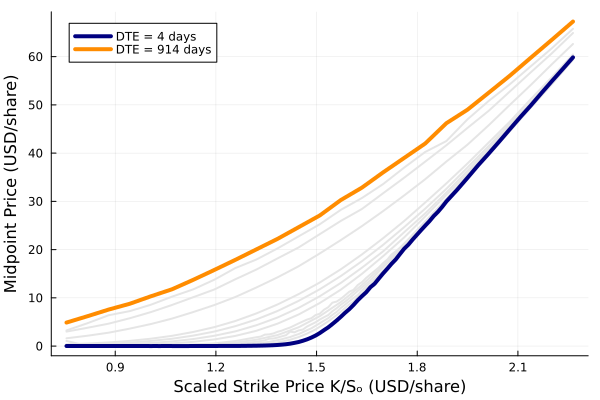

In [119]:
let
    p = plot();
    for dte_value ∈ DTEs
        dataframe = list_of_options_chains[dte_value];
        plot!(dataframe[:,:strike]/Sₒ, dataframe[:,:midpoint], label="", lw=2, c = :gray90);
    end
    current()
    plot!(list_of_options_chains[4][:,:strike]/Sₒ, list_of_options_chains[4][:,:midpoint],
        lw=4, label="DTE = 4 days", c=:navyblue)
    plot!(list_of_options_chains[914][:,:strike]/Sₒ, list_of_options_chains[914][:,:midpoint],
        lw=4, label="DTE = 914 days", c=:darkorange)
    xlabel!("Scaled Strike Price K/Sₒ (USD/share)", fontsize = 18)
    ylabel!("Midpoint Price (USD/share)", fontsize = 18)
end

## Task 2: Estimate the Implied Volatility `IV` from the `AMD` pricing data
Implied volatility, or `IV,` is the market's prediction of the future volatility of the underlying asset's price. It is a crucial factor in option pricing models and is calculated from the current market prices of option contracts rather than being directly observed. Let's use pricing data to compute the unknown implied volatility values for `AMD` options in our options `dataset`.

### Check: Test the IV calculation for an `MU` put option
Before computing the unknown `AMD` values, let's check our implementation on contracts with known `IV` values. In particular, let's estimate the implied volatility for a `put` option on [Micron Technology](https://finance.yahoo.com/quote/MU/), which has the ticker symbol `MU,` and compare our estimated value with the published market value. The parameters for this option are (assume there are `365` days per year):
* The `put` contract has a strike price of `K = 75` USD/share and has `T = 62 days` to expiration. The current share price of `MU` is $S_{o}$ = `79.50 USD/share`, and the risk-free-rate is `r̄ = 4.9%`. The midpoint premium for this contract is $\mathcal{P}_{p}$ = `2.93` USD/share, and the implied volatility `IV = 0.4005`.

In [23]:
r̄ = 0.049; # risk free rate
Δt = (1/365); # step-size, assuming 365-trading days per year
T = 62*Δt; # duration of the contract (units: years)
IV = 0.4005; # implied volatility - we are estimating this
Sₒ = 79.50; # share price at contract purchase (units: USD/share)
K = 75.0; # strike price for the MU contract (units: USD/share)
h = 124; # number of levels in the binomial tree
𝒫 = 2.93; # contract premium (midpoint)

To begin this check, create an instance of the `MyAmericanPutContractModel` type, which holds the data for the contract information using the `build(...)` method. We store this instance in the `test_american_put_contract_model` variable:

In [25]:
test_american_put_contract_model = build(MyAmericanPutContractModel, (
        K = K, sense = 1, copy = 1, DTE = T, IV = 0.1, premium = 𝒫));

Next, let's estimate the implied volatility using the `estimate_implied_volatility(...)` function. This function takes a contract model and parameters associated with the options price, namely, the current share price of the underlying asset `Sₒ,` the number of levels in the tree `h,` and the risk-free rate `r̄.` It returns an estimate of the implied volatility.
* The estimation method requires an initial guess for the implied volatility `IV.` Since we are not sure what the value is, we simulate a range of possible initial values (store the resulting `IV` estimates in the `test_IV_array` variable) and compute the mean value using the [mean function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.mean) exported by the [Statistics package](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics):

In [27]:
initial_guess_vector = range(0.2,stop=0.6,length=3) |> collect;
test_IV_array = Array{Float64,1}(); # holds the estimated IV values
for iv_value ∈ initial_guess_vector
    test_american_put_contract_model.IV = iv_value; # update the IV value on the model with our guess
    estimate_implied_volatility(test_american_put_contract_model, 
        Sₒ = Sₒ, h = h, r̄ = r̄) |> x-> push!(test_IV_array,x);
end
IV_computed = mean(test_IV_array); # compute the mean of the estimated IV values
println("The computed expected implied volatility: $(IV_computed)")

The computed expected implied volatility: 0.4009963989257812


Finally, let's compare the estimated and observed `IV` values using the [@assert macro](https://docs.julialang.org/en/v1/base/base/#Base.@assert) in combination with the [isapprox function](https://docs.julialang.org/en/v1/base/math/#Base.isapprox). If the values differ by more than a specified tolerance (in this case, `atol = 1e-3`), then an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) is thrown:

In [29]:
@assert isapprox(IV_computed,IV,atol = 1e-3);

### Compute the implied volatility of `AMD` contracts as a function of the days to expiration
Fill me in.

In [31]:
K̂ = 130;

In [32]:
list_of_AMD_contracts = Dict{Int64,DataFrame}();
DTEs = keys(dataset) |> collect |> sort;
for dte_value ∈ DTEs
    dataframe = search(dataset, dte_value, (DTE::Int64, record::Dict{String, Any}) -> begin

            # initialize -
            should_keep_record = false;
            K = record["details"]["strike_price"]; # get the strike price from the record
            if (record["details"]["contract_type"] == "put" && (K == K̂) && DTE < 120)
                should_keep_record = true
            end;
            
            # return -
            return should_keep_record;
        end
    );

    if (nrow(dataframe) != 0)
        list_of_AMD_contracts[dte_value] = dataframe;
    end
end

In [33]:
list_of_AMD_contracts

Dict{Int64, DataFrame} with 8 entries:
  32 => 1×6 DataFrame…
  4  => 1×6 DataFrame…
  39 => 1×6 DataFrame…
  11 => 1×6 DataFrame…
  25 => 1×6 DataFrame…
  18 => 1×6 DataFrame…
  60 => 1×6 DataFrame…
  88 => 1×6 DataFrame…

In [34]:
tmp_contract_model = build(MyAmericanPutContractModel, (
        K = K̂, sense = 1, copy = 1, DTE = 914*Δt, IV = 0.49, premium = 27.075)); # we'll update values below

Now that we have the list of contracts with strike $\hat{K}$ as a function of the days to expiration, we can estimate the implied volatility `IV` for each contract, and explore how the `IV` changes as a function of the days to expiration.

In [36]:
DTE_array = keys(list_of_AMD_contracts) |> collect |> x-> sort(x,rev=true)
IV_results_array = Array{Float64,2}(undef, length(DTE_array),2);
for i ∈ eachindex(DTE_array)

    record = list_of_AMD_contracts[DTE_array[i]];
    tmp_contract_model.IV = 0.5; # intial guess 
    tmp_contract_model.DTE = DTE_array[i]*Δt; # T is the duration of the contract, measured in years
    tmp_contract_model.premium = record[!,:midpoint][1]

    # estimate -
    IV_results_array[i,1] = DTE_array[i] |> x-> convert(Float64,x);
    IV_results_array[i,2] = estimate_implied_volatility(tmp_contract_model, Sₒ = record[!,:underlying][1], h = 360, r̄ = r̄);
end

In [37]:
IV_results_array

8×2 Matrix{Float64}:
 88.0  0.455688
 60.0  0.469922
 39.0  0.449243
 32.0  0.445215
 25.0  0.448438
 18.0  0.445215
 11.0  0.428027
  4.0  0.29375

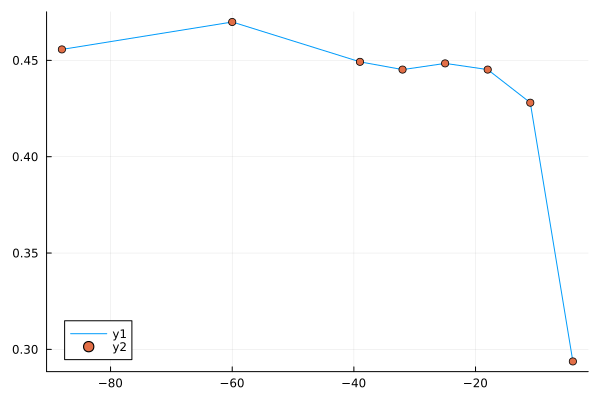

In [38]:
plot(-1*IV_results_array[:,1],IV_results_array[:,2])
scatter!(-1*IV_results_array[:,1],IV_results_array[:,2])

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.